Описание эксперимента

Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Описание колонок

value – значения метрики

experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

Задача

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [ ]:
import pandas as pd
import numpy as np

import scipy.stats as ss
from scipy.stats import norm
from tqdm.auto import tqdm
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [54]:
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Statistics/Bootstrap/hw_bootstrap.csv', sep=';', decimal=",")
data

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   value              1000 non-null   float64
 2   experimentVariant  1000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [56]:
# Контрольная и тестовая группы одинаковы по количеству наблюдений.

data.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [57]:
data.value.min()

6.436540758631621

In [58]:
data.value.max()

3000.0

На первый взгляд, довольно странным выглядит факт значительного разброса значений метрики, поэтому построим распределения для каждой из групп, предварительно подготовив данные. Возможно наличие в данных некоторых аномалий или выбросов.

In [59]:
data_control = data.query('experimentVariant == "Control"')
data_control

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
495,496,10.973929,Control
496,497,10.261074,Control
497,498,8.780090,Control
498,499,11.169078,Control


In [60]:
data_control.value.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

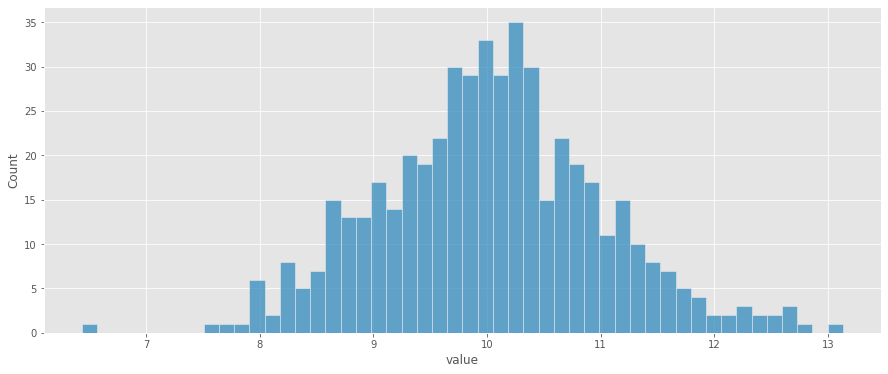

In [61]:
# Судя по гистограмме, данные распределены нормально, выбросов не обнаружено.

fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=data_control, x='value', bins=50)
fig.show()

In [62]:
# Выборка содержит 500 наблюдений, поэтому используем scipy.stats.normaltest().
# Тест подтверждает нормальность распределения

ss.normaltest(data_control.value)

NormaltestResult(statistic=2.9434587202565154, pvalue=0.22952820483957936)

Проделаем те же манипуляции для тестовой группы

In [63]:
data_test = data.query('experimentVariant == "Treatment"')
data_test

,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [64]:
# Очевидно, в данных присутствуют выбросы

data_test.value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

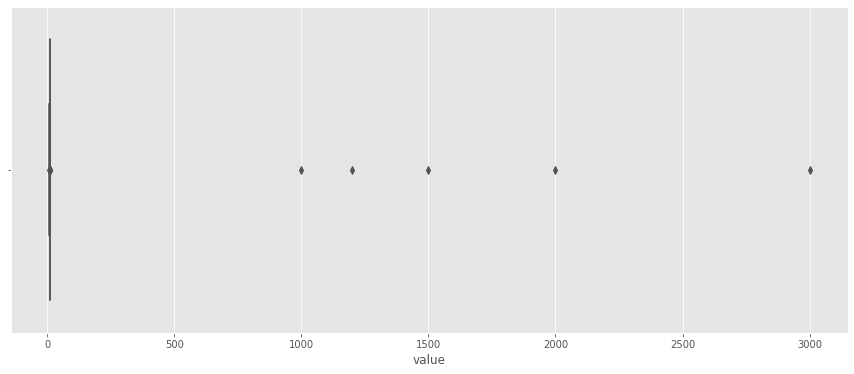

In [65]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data_test, x='value')
fig.show()

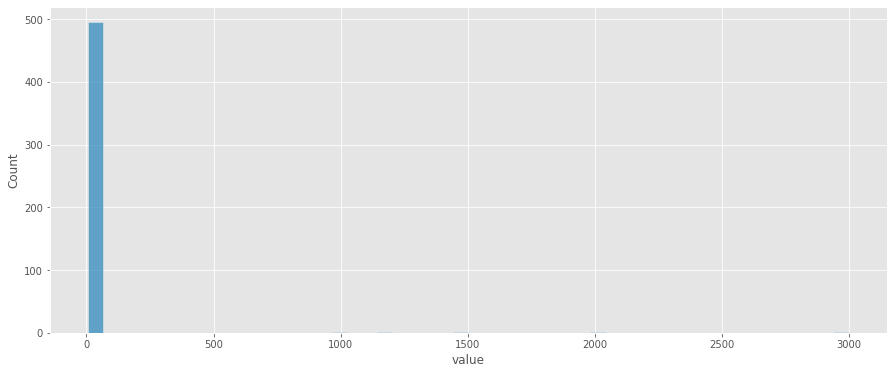

In [66]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=data_test, x='value', bins=50)
fig.show()

In [67]:
data_test.query('value > 500').value_counts()

Unnamed: 0  value   experimentVariant
1000        3000.0  Treatment            1
999         2000.0  Treatment            1
998         1500.0  Treatment            1
997         1200.0  Treatment            1
996         1000.0  Treatment            1
dtype: int64

В датасете data_test имеется 5 выбросов в колонке value. Возможно, они обусловлены ошибкой ввода данных, соответственно, существует два наиболее разумных варианта действий в данной ситуации: удалить выбросы и анализировать оставшиеся данные или заменить их на медианное значение по выборке, рассчитанное без значений выбросов. 
В данном случае, я предпочту второй вариант, чтобы в дальнейшем при анализе данных мы оперировали выборками с одинаковым количеством наблюдений.

In [68]:
# Рассчитаем медианное значение value без выбросов

x = data_test.query('value < 500').value.median()
x

10.0154916649155

In [69]:
# Заменим значения выбросов на полученное значение медианы

data_test.loc[(data_test.value > 500), 'value'] = x
data_test

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment
...,...,...,...
995,996,10.015492,Treatment
996,997,10.015492,Treatment
997,998,10.015492,Treatment
998,999,10.015492,Treatment


In [70]:
data_test.value.describe()

count    500.000000
mean      10.021654
std        0.973227
min        6.436541
25%        9.421968
50%       10.015492
75%       10.639569
max       13.130346
Name: value, dtype: float64

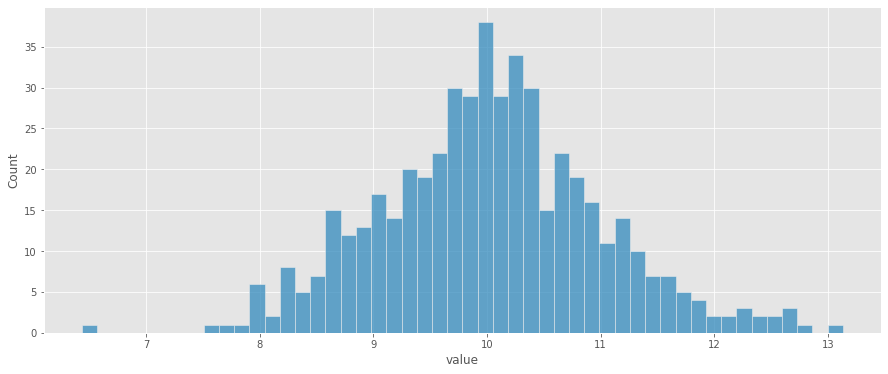

In [71]:
# Теперь данные распределены нормально

fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=data_test, x='value', bins=50)
fig.show()

In [72]:
ss.normaltest(data_test.value)

NormaltestResult(statistic=3.8235653577052844, pvalue=0.14781664197761113)

   Для применения критерия t-Стьюдента необходимо, чтобы исходные данные имели нормальное распределение. В случае применения двухвыборочного критерия для независимых выборок также необходимо соблюдение условия равенства дисперсий. Оба условия соблюдаются.
   T-тест проводится, если число наблюдений в выборке невелико (как правило, меньше 30) и стандартное отклонение генеральной совокупности неизвестно. В данном случае, проведение t-теста нецелесообразно, т.к. выборки содержат по 500 наблюдений с известным стандартным отклонением. Однако, всё же проверим нулевую гипотезу о том, что средние в выборках control и treatment значимо не отличаются. Для этого проведем t-тест.  

In [73]:
# P-value больше 0.05, поэтому мы принимаем нулевую гипотезу и делаем вывод, что средние в группах значимо не различаются, 
# соответственно статистически значимых различий по выручке в группах control и treatment нет.  

ss.ttest_ind(data_control.value, data_test.value)

Ttest_indResult(statistic=0.0844179303865862, pvalue=0.9327410821363553)

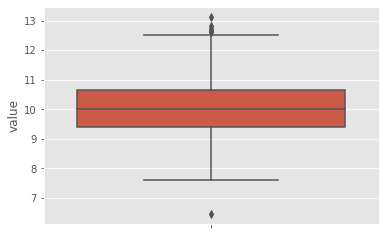

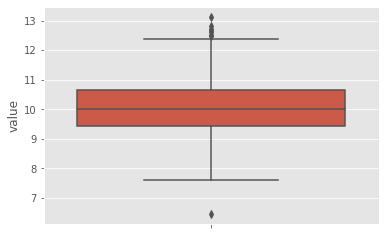

In [74]:
# Графики показывают практически идентичное распределение (К сожалению, после двух часов безуспешных попыток сделать графики 
# рядом на одном листе, я сдался...)

sns.boxplot(data=data_control, y='value')
plt.show()
sns.boxplot(data=data_test, y='value')
plt.show()

   U-критерий Манна-Уитни — это непараметрический тест нулевой гипотезы о том, что распределение, лежащее в основе выборки x, совпадает с распределением, лежащим в основе выборки y. Иными словами - это критерий статистической значимости для определения того, были ли взяты две независимые выборки из генеральной совокупности с одинаковым распределением.
   Нулевая гипотеза заключается в том, что нет различий между распределениями выборок данных. Отказ от этой гипотезы позволяет предположить, что между образцами, вероятно, существует некоторое различие.
   Ограничения применимости критерия: 
   1. В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
   2. В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).

In [75]:
data_control.value.nunique()

500

In [76]:
# Мы целенаправленно заменили 5 значений, являющихся выбросами, на медианное значение распределения.

data_test.value.nunique()

495

In [77]:
# Как и в случае с t-тестом, P-value больше 0.05, поэтому мы принимаем нулевую гипотезу и делаем вывод, 
# что нет статистически значимых различий между распределениями выборок данных. Распределения групп control и treatment 
# выглядят практически одинаково.

ss.mannwhitneyu(data_control.value, data_test.value)

MannwhitneyuResult(statistic=125447.0, pvalue=0.9221113285012477)

Бутстрэп-процедура состоит в многократном извлечении подвыборок из эмпирического распределения. Обладая только данными по имеющейся выборке, у нас есть возможность оценить любой её параметр, построив эмпирическое распределение параметра.

In [78]:
# Группа control 

boot_it = 2000
boot_data_control = []
boot_conf_level = 0.95
for i in range(boot_it):
    samples = data_control['value'].sample(len(data_control['value']), replace = True)
    boot_data_control.append(np.median(samples))

print(f'Original: {np.mean(data_control["value"])}, Boot: {np.mean(boot_data)}')

Original: 10.026866533804295, Boot: 10.018611551424423


In [79]:
# Найдем доверительный интервал

left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data_control).quantile([left_ci, right_ci])

print(ci)

0.025     9.925038
0.975    10.116160
dtype: float64


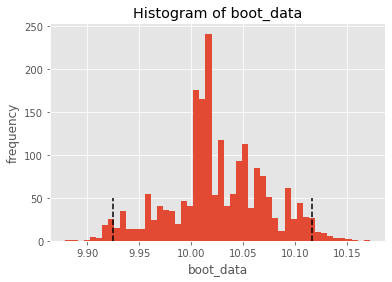

In [80]:
# Гистограмма распределения

plt.hist(pd.Series(boot_data_control), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

In [81]:
# Группа treatment 

boot_it = 2000
boot_data_test = []
boot_conf_level = 0.95
for i in range(boot_it):
    samples = data_test['value'].sample(len(data_test['value']), replace = True)
    boot_data_test.append(np.median(samples))

print(f'Original: {np.mean(data_test["value"])}, Boot: {np.mean(boot_data)}')

Original: 10.021653973310732, Boot: 10.018611551424423


In [82]:
# Найдем доверительный интервал

left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data_test).quantile([left_ci, right_ci])

print(ci)

0.025     9.934638
0.975    10.099056
dtype: float64


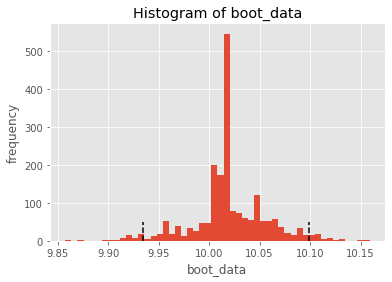

In [83]:
# Гистограмма распределения

plt.hist(pd.Series(boot_data_test), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

In [84]:
# Считаем распределение разницы и доверительный интервал.

def get_bootstrap(
    data_control, # числовые значения первой выборки
    data_test, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_control.value.sample(
            len(data_control.value), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_test.value.sample(
            len(data_control.value), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

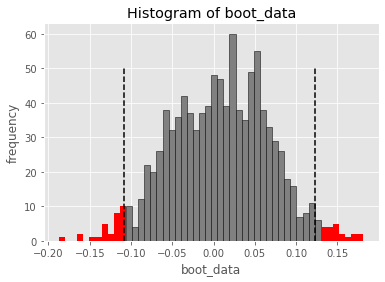

In [85]:
# Ноль попадает в доверительный интервал, нулевая гипотеза об отсутствии значимых различий принимается.

booted_data = get_bootstrap(data_control, data_test)

In [86]:
# P-value > 0.05, нулевая гипотеза об отсутствии значимых различий принимается.

booted_data["p_value"]

0.89064511672152

In [87]:
# Ноль попадает в доверительный интервал, нулевая гипотеза об отсутствии значимых различий принимается.

booted_data["quants"]

,0
0.025,-0.108727
0.975,0.123024


   Во всех применённых тестах полученные значения p-value примерно одинаковы:
   - Ttest_indResult(statistic=0.0844179303865862, pvalue=0.9327410821363553)
   - MannwhitneyuResult(statistic=125447.0, pvalue=0.9221113285012477)
   - Bootstrap(pvalue=0.9117425859203095)
   Это говорит об отсутствии статистически значимых различий между результатами эксперимента в контрольной и тестовой группах.
   
   В данном случае, если не принимать в расчет имеющиеся выбросы, распределения являются нормальными с известным стандартным отклонением, выборки одинаковы по количеству наблюдений. Поэтому для анализа целесообразно и допустимо применять любой из рассмотренных тестов, однако bootstrap, вероятно, является наиболее наглядным и удобным при проведении А/В тестов, особенно при наличии аномалий в данных, ненормальности распределений в выборках и т.п. 

# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

Хорошего дня!